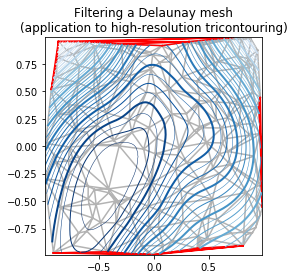

In [3]:
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


#-----------------------------------------------------------------------------
# Analytical test function
#-----------------------------------------------------------------------------
def experiment_res(x, y):
    """An analytic function representing experiment results."""
    x = 2 * x
    r1 = np.sqrt((0.5 - x)**2 + (0.5 - y)**2)
    theta1 = np.arctan2(0.5 - x, 0.5 - y)
    r2 = np.sqrt((-x - 0.2)**2 + (-y - 0.2)**2)
    theta2 = np.arctan2(-x - 0.2, -y - 0.2)
    z = (4 * (np.exp((r1/10)**2) - 1) * 30 * np.cos(3 * theta1) +
         (np.exp((r2/10)**2) - 1) * 30 * np.cos(5 * theta2) +
         2 * (x**2 + y**2))
    return (np.max(z) - z) / (np.max(z) - np.min(z))

#-----------------------------------------------------------------------------
# Generating the initial data test points and triangulation for the demo
#-----------------------------------------------------------------------------
# User parameters for data test points
n_test = 200  # Number of test data points, tested from 3 to 5000 for subdiv=3

subdiv = 3  # Number of recursive subdivisions of the initial mesh for smooth
            # plots. Values >3 might result in a very high number of triangles
            # for the refine mesh: new triangles numbering = (4**subdiv)*ntri

init_mask_frac = 0.0    # Float > 0. adjusting the proportion of
                        # (invalid) initial triangles which will be masked
                        # out. Enter 0 for no mask.

min_circle_ratio = .01  # Minimum circle ratio - border triangles with circle
                        # ratio below this will be masked if they touch a
                        # border. Suggested value 0.01; use -1 to keep
                        # all triangles.

# Random points
random_gen = np.random.RandomState(seed=19680801)
x_test = random_gen.uniform(-1., 1., size=n_test)
y_test = random_gen.uniform(-1., 1., size=n_test)
z_test = experiment_res(x_test, y_test)

# meshing with Delaunay triangulation
tri = Triangulation(x_test, y_test)
ntri = tri.triangles.shape[0]

# Some invalid data are masked out
mask_init = np.zeros(ntri, dtype=bool)
masked_tri = random_gen.randint(0, ntri, int(ntri * init_mask_frac))
mask_init[masked_tri] = True
tri.set_mask(mask_init)


#-----------------------------------------------------------------------------
# Improving the triangulation before high-res plots: removing flat triangles
#-----------------------------------------------------------------------------
# masking badly shaped triangles at the border of the triangular mesh.
mask = TriAnalyzer(tri).get_flat_tri_mask(min_circle_ratio)
tri.set_mask(mask)

# refining the data
refiner = UniformTriRefiner(tri)
tri_refi, z_test_refi = refiner.refine_field(z_test, subdiv=subdiv)

# analytical 'results' for comparison
z_expected = experiment_res(tri_refi.x, tri_refi.y)

# for the demo: loading the 'flat' triangles for plot
flat_tri = Triangulation(x_test, y_test)
flat_tri.set_mask(~mask)


#-----------------------------------------------------------------------------
# Now the plots
#-----------------------------------------------------------------------------
# User options for plots
plot_tri = True          # plot of base triangulation
plot_masked_tri = True   # plot of excessively flat excluded triangles
plot_refi_tri = False    # plot of refined triangulation
plot_expected = False    # plot of analytical function values for comparison


# Graphical options for tricontouring
levels = np.arange(0., 1., 0.025)
cmap = cm.get_cmap(name='Blues', lut=None)

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title("Filtering a Delaunay mesh\n" +
          "(application to high-resolution tricontouring)")

# 1) plot of the refined (computed) data contours:
ax.tricontour(tri_refi, z_test_refi, levels=levels, cmap=cmap,
               linewidths=[2.0, 0.5, 1.0, 0.5])
# 2) plot of the expected (analytical) data contours (dashed):
if plot_expected:
    ax.tricontour(tri_refi, z_expected, levels=levels, cmap=cmap,
                   linestyles='--')
# 3) plot of the fine mesh on which interpolation was done:
if plot_refi_tri:
    ax.triplot(tri_refi, color='0.97')
# 4) plot of the initial 'coarse' mesh:
if plot_tri:
    ax.triplot(tri, color='0.7')
# 4) plot of the unvalidated triangles from naive Delaunay Triangulation:
if plot_masked_tri:
    ax.triplot(flat_tri, color='red')

plt.show()